In [120]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Load dataset
Train = pd.read_csv("/Users/vignesh/RStudio/IDA_Homework/IDA_HW_8/wine+quality/winequality-red.csv", delimiter=";")
Train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [60]:

# Remove duplicates
Train = Train.drop_duplicates()
Train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
5,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1593,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [61]:

# Separate quality column
quality = Train.pop('quality')
quality

0       5
1       5
2       5
3       6
5       5
       ..
1593    6
1594    5
1595    6
1597    5
1598    6
Name: quality, Length: 1359, dtype: int64

In [123]:

# Summary statistics
def my_numeric_summary(x):
    return {
        'n': len(x),
        'unique': x.nunique(),
        'missing': x.isna().sum(),
        'mean': x.mean(),
        'min': x.min(),
        'Q1': x.quantile(0.25),
        'median': x.median(),
        'Q3': x.quantile(0.75),
        'max': x.max(),
        'sd': x.std()
    }

numeric_summary = pd.DataFrame({col: my_numeric_summary(Train[col]) for col in Train}).T
numeric_summary



,n,unique,missing,mean,min,Q1,median,Q3,max,sd
fixed acidity,1599.0,96.0,0.0,8.319637,4.60000,7.1000,7.90000,9.200000,15.90000,1.741096
volatile acidity,1599.0,143.0,0.0,0.527821,0.12000,0.3900,0.52000,0.640000,1.58000,0.179060
citric acid,1599.0,80.0,0.0,0.270976,0.00000,0.0900,0.26000,0.420000,1.00000,0.194801
residual sugar,1599.0,91.0,0.0,2.538806,0.90000,1.9000,2.20000,2.600000,15.50000,1.409928
chlorides,1599.0,153.0,0.0,0.087467,0.01200,0.0700,0.07900,0.090000,0.61100,0.047065
free sulfur dioxide,1599.0,60.0,0.0,15.874922,1.00000,7.0000,14.00000,21.000000,72.00000,10.460157
total sulfur dioxide,1599.0,144.0,0.0,46.467792,6.00000,22.0000,38.00000,62.000000,289.00000,32.895324
density,1599.0,436.0,0.0,0.996747,0.99007,0.9956,0.99675,0.997835,1.00369,0.001887
pH,1599.0,89.0,0.0,3.311113,2.74000,3.2100,3.31000,3.400000,4.01000,0.154386
sulphates,1599.0,96.0,0.0,0.658149,0.33000,0.5500,0.62000,0.730000,2.00000,0.169507


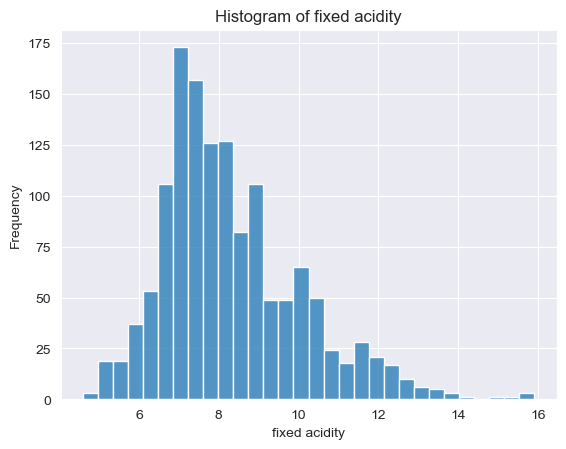

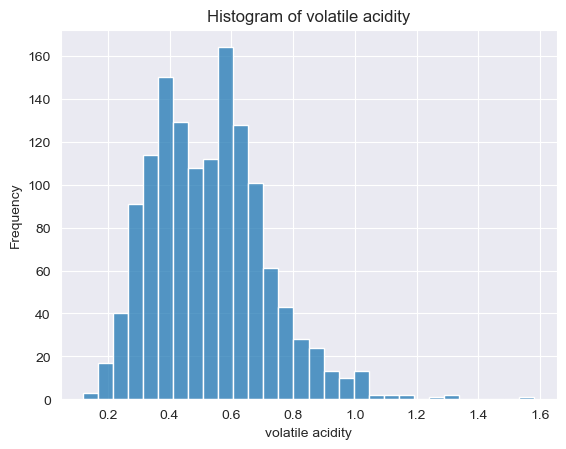

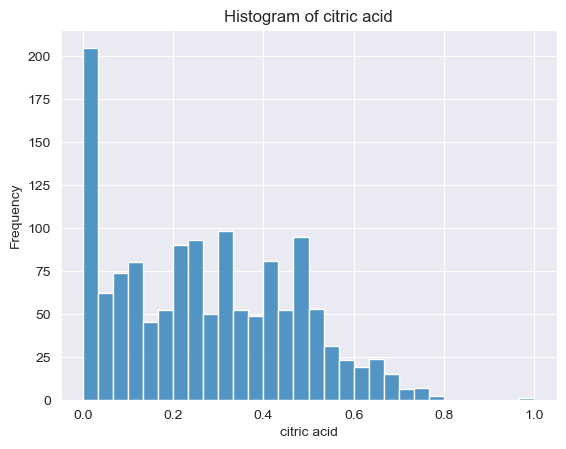

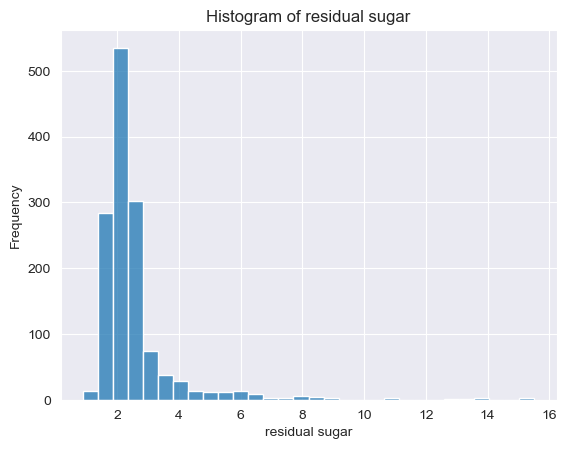

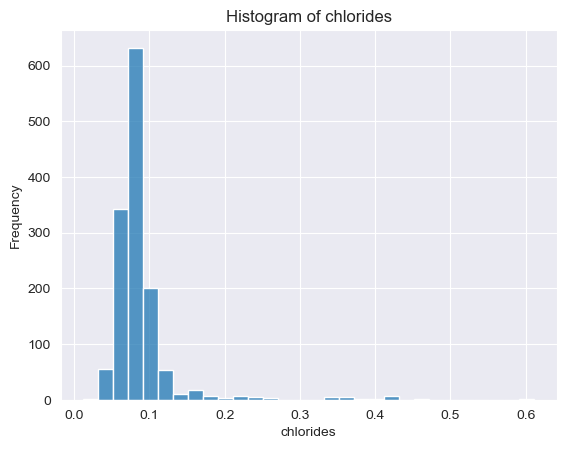

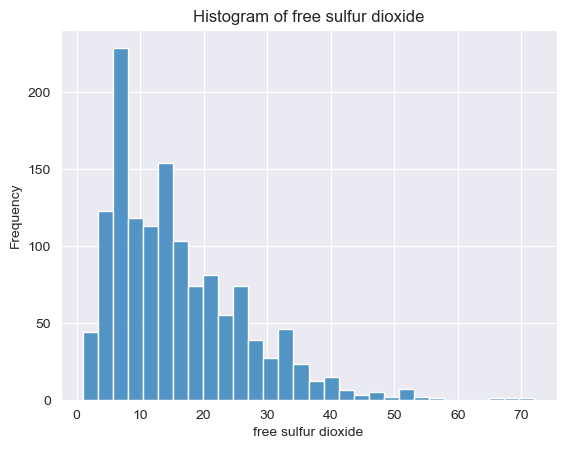

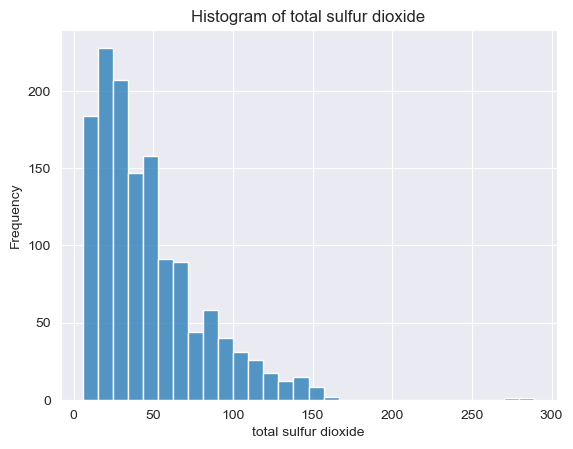

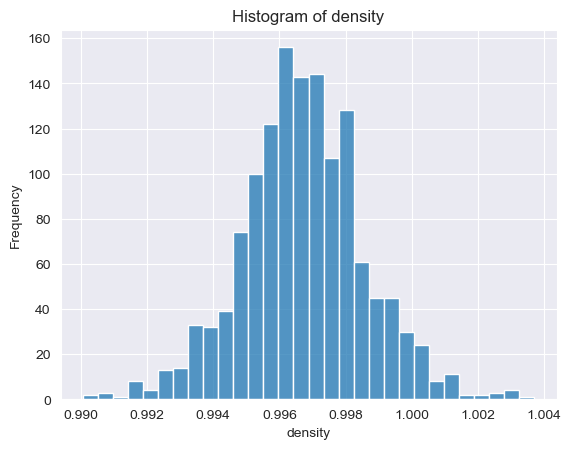

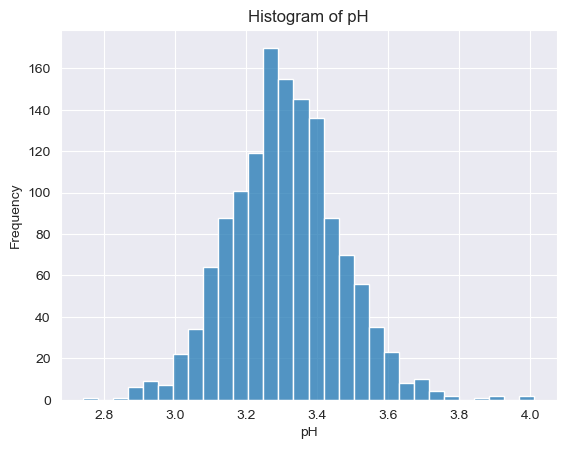

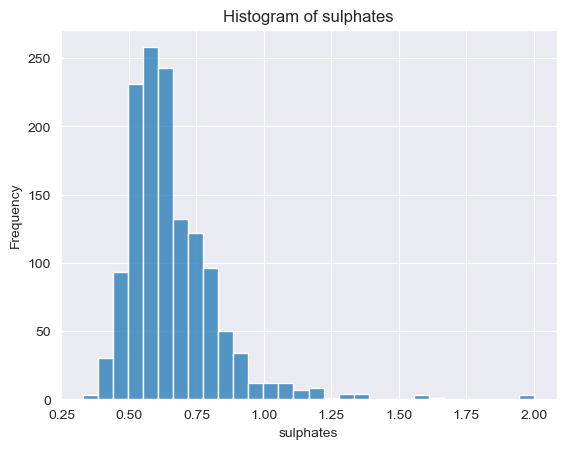

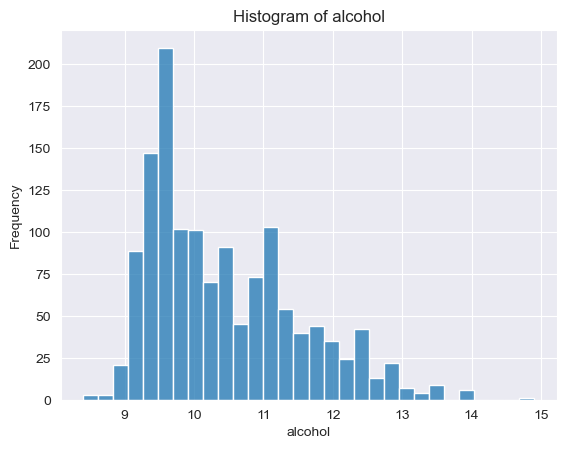

In [63]:
# Histograms
for col in Train.columns:
    sns.histplot(Train[col], bins=30, kde=False)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


In [64]:

# Skewness
skew_values = Train.apply(lambda x: skew(x, nan_policy='omit')).sort_values(ascending=True)
print(skew_values)

density                 0.044728
pH                      0.231776
citric acid             0.312380
volatile acidity        0.728474
alcohol                 0.858892
fixed acidity           0.940002
free sulfur dioxide     1.225225
total sulfur dioxide    1.538667
sulphates               2.403848
residual sugar          4.543132
chlorides               5.496412
dtype: float64


In [66]:
box_cox_results = {}

for col in Train.columns:
    if Train[col].min() > 0:  # Box-Cox requires positive data
        transformer = PowerTransformer(method='box-cox', standardize=False)
        transformer.fit(Train[[col]])  # Fit the transformer
        # Store the transformer and transformed data
        box_cox_results[col] = {
            'transformer': transformer,
            'lambda': transformer.lambdas_[0],  # Box-Cox parameter λ
            'transformed_data': transformer.transform(Train[[col]]).flatten()  # Transformed data
        }

# Display λ and transformed data for each column
for col, results in box_cox_results.items():
    print(f"Column: {col}")
    print(f"  Lambda (Box-Cox parameter): {results['lambda']}")
    print()

Column: fixed acidity
  Lambda (Box-Cox parameter): -0.5879651681954421

Column: volatile acidity
  Lambda (Box-Cox parameter): 0.3204449972498362

Column: residual sugar
  Lambda (Box-Cox parameter): -1.1875096986844094

Column: chlorides
  Lambda (Box-Cox parameter): -0.5713682764909029

Column: free sulfur dioxide
  Lambda (Box-Cox parameter): 0.14008744576252927

Column: total sulfur dioxide
  Lambda (Box-Cox parameter): 0.050225108762251613

Column: density
  Lambda (Box-Cox parameter): -4.963078812516455

Column: pH
  Lambda (Box-Cox parameter): -0.22302504135353313

Column: sulphates
  Lambda (Box-Cox parameter): -1.1215779609526997

Column: alcohol
  Lambda (Box-Cox parameter): -3.339705629133355



In [67]:

# Box-Cox Transformation
power_transformer = PowerTransformer(method='box-cox', standardize=False)
for col in Train.columns:
    if Train[col].min() > 0:  # Box-Cox requires positive data
        Train[col] = power_transformer.fit_transform(Train[[col]])

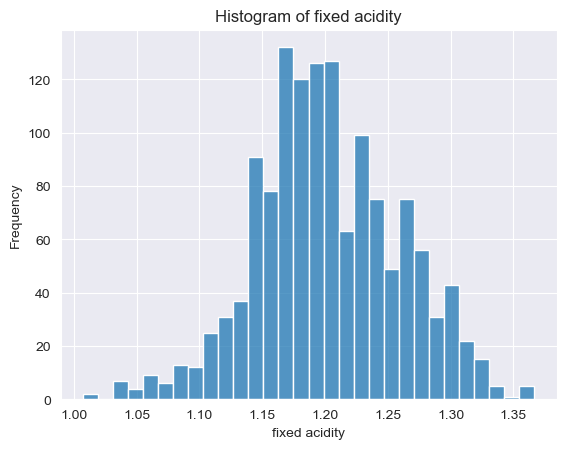

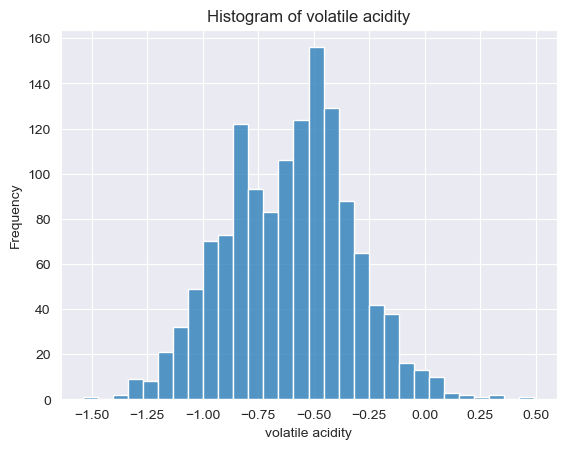

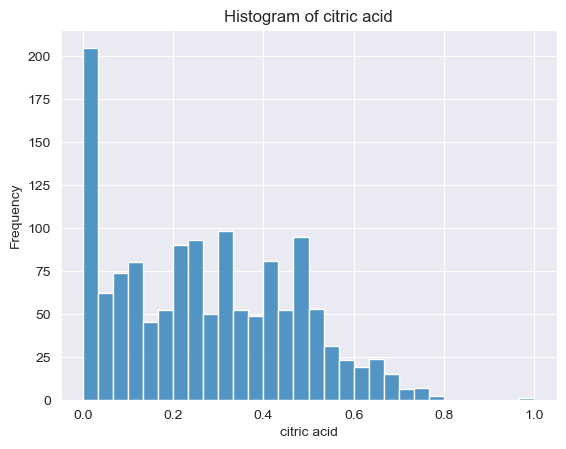

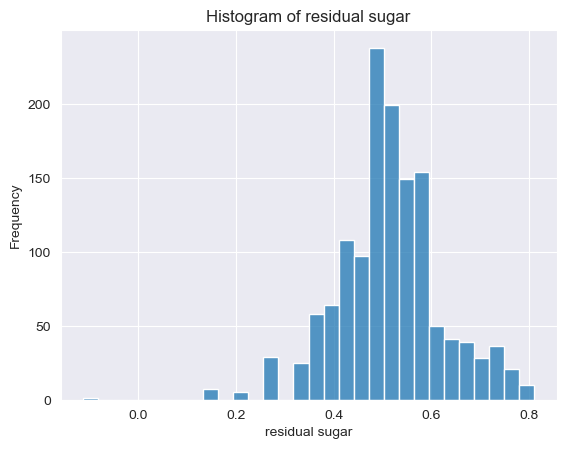

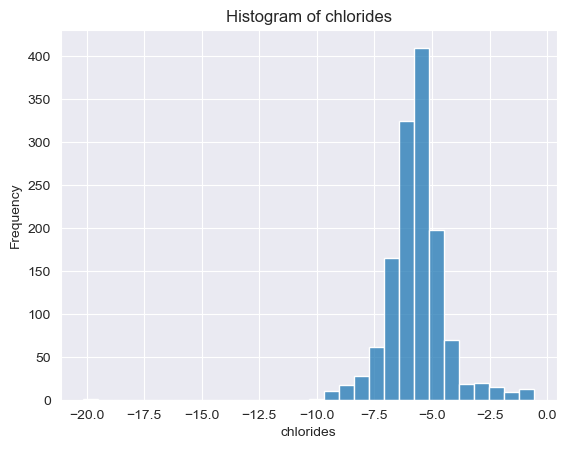

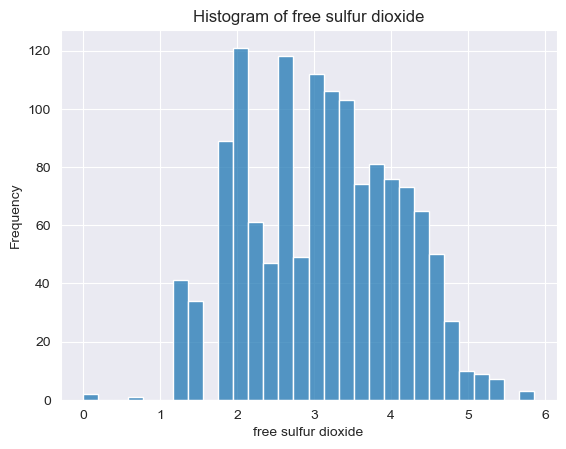

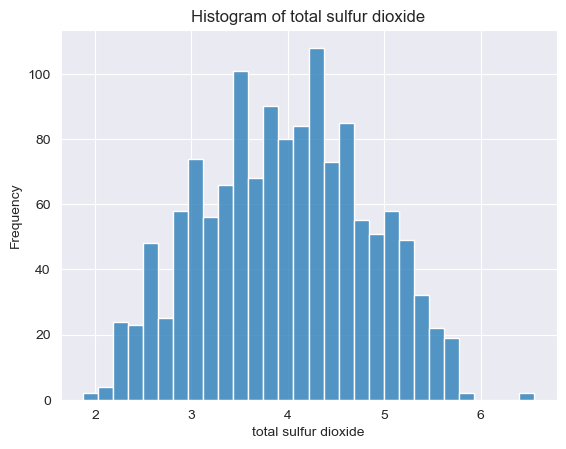

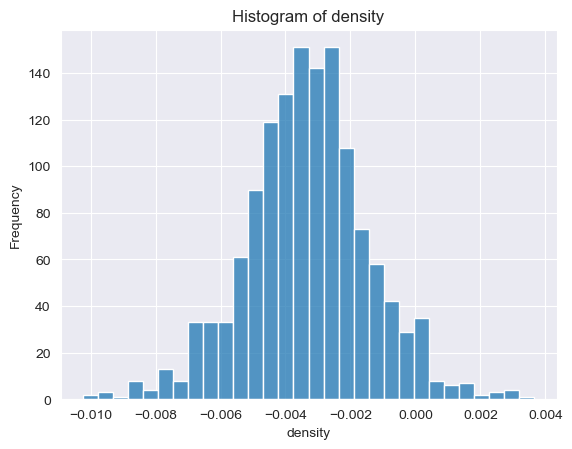

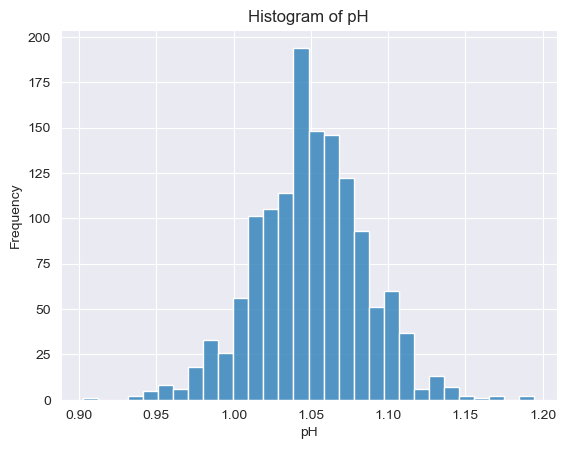

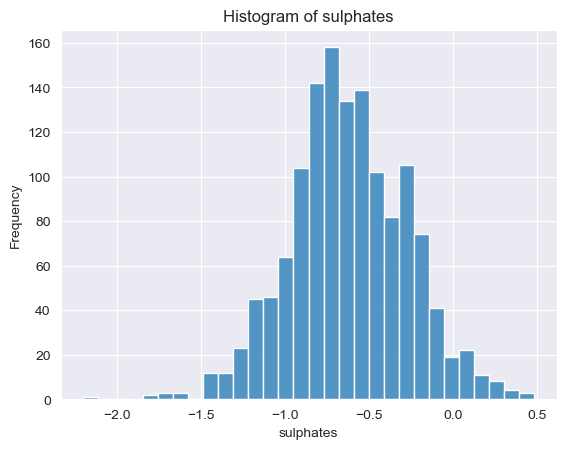

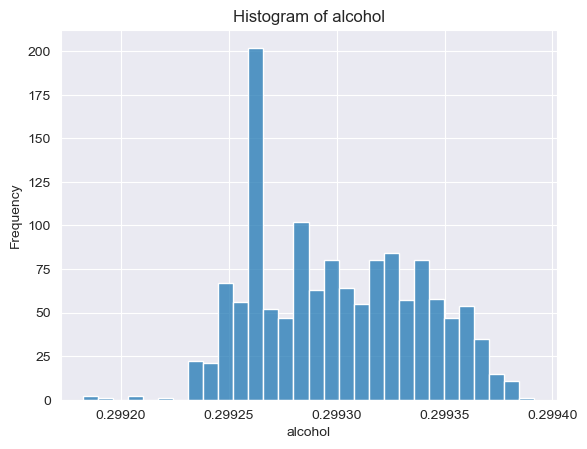

In [68]:
# Histograms
for col in Train.columns:
    sns.histplot(Train[col], bins=30, kde=False)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

In [69]:

# Scaling and centering
scaler = StandardScaler()
Train_scaled = scaler.fit_transform(Train)

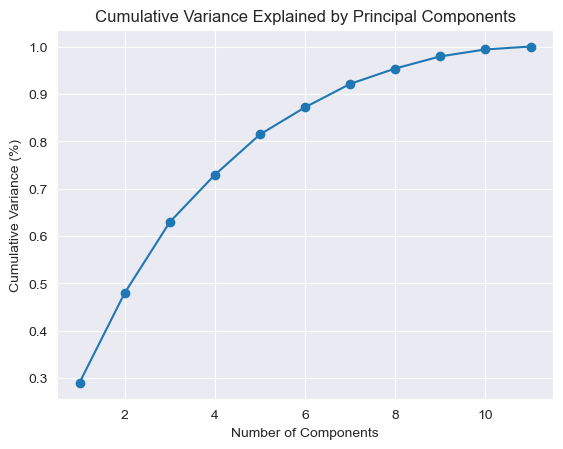

In [71]:

# PCA
pca = PCA()
pca_result = pca.fit_transform(Train_scaled)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Scree Plot

plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title('Cumulative Variance Explained by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance (%)')
plt.show()


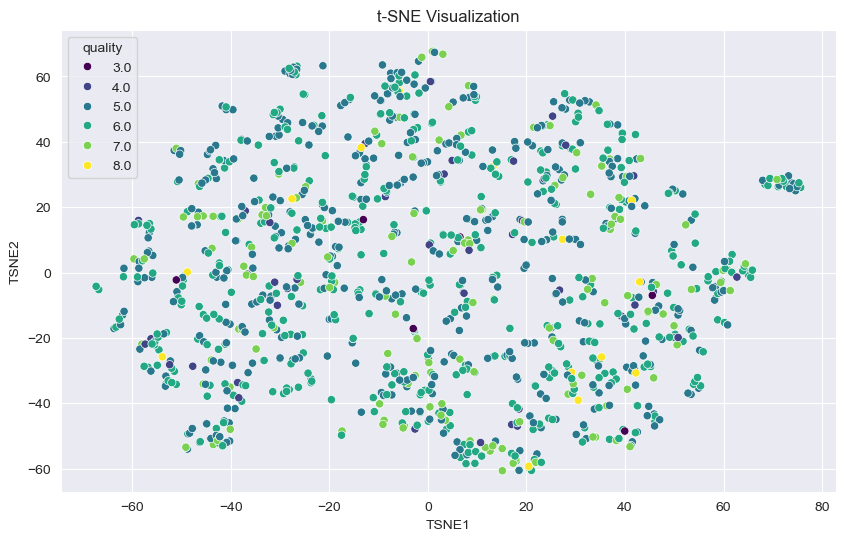

In [104]:

# t-SNE
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
tsne_result = tsne.fit_transform(Train_scaled)
tsne_data = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])
tsne_data['quality'] = quality

plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_data, x='TSNE1', y='TSNE2', hue='quality',palette='viridis')
plt.title('t-SNE Visualization')
plt.show()


In [119]:
tsne_data.drop("kmeans_cluster", axis=1)

,TSNE1,TSNE2,quality
0,-30.902666,41.726482,5.0
1,-0.077040,33.871902,5.0
2,-0.922885,33.641972,5.0
3,49.465527,6.684259,6.0
4,-30.731880,41.521339,NaN
...,...,...,...
1354,-45.867535,27.371651,5.0
1355,-35.614689,-27.696352,5.0
1356,-30.007837,-26.111576,5.0
1357,-33.240482,-26.885218,6.0


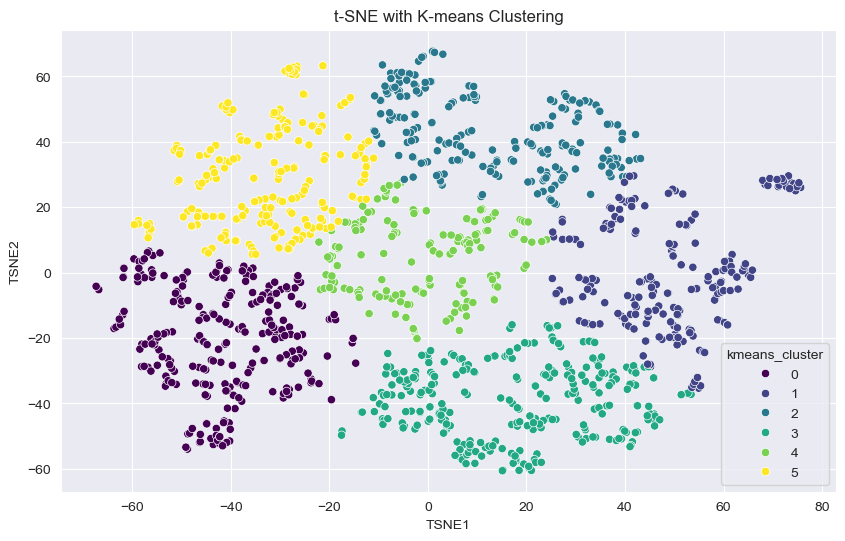

In [117]:

# K-means Clustering
kmeans = KMeans(n_clusters=6)
tsne_data['kmeans_cluster'] = kmeans.fit_predict(tsne_result)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_data, x='TSNE1', y='TSNE2', hue='kmeans_cluster', palette='viridis')
plt.title('t-SNE with K-means Clustering')
plt.show()


In [82]:
kmeans_result = KMeans(n_clusters=6, n_init=25, random_state=42)
kmeans_result.fit(Train_scaled)

# Print the results
print("Cluster Centers:")
print(kmeans_result.cluster_centers_)  # Centroids of the clusters

print("\nLabels:")
print(kmeans_result.labels_)  # Cluster assignments for each data point

print("\nInertia (Sum of Squared Distances to Closest Cluster Center):")
print(kmeans_result.inertia_)  # Inertia value

print("\nNumber of Iterations Run:")
print(kmeans_result.n_iter_)  # Number of iterations performed

Cluster Centers:
[[ 0.2871067  -1.17190577  0.73399982 -0.28455455 -0.47817045 -0.3549516
  -0.64480441 -0.61695343 -0.19104228  0.50424788  0.94019944]
 [-0.37007742  0.70461657 -0.84000383 -0.32874209  0.07381909 -0.60866455
  -0.60035839 -0.05796832  0.34048188 -0.53109926 -0.44182628]
 [-1.29645628  0.38642815 -0.87499487 -0.28870545 -0.82536086  0.46830497
   0.11261253 -1.23266584  1.12278653 -0.02795778  0.98943048]
 [ 0.46338632 -0.09543774  0.90599775 -0.61069044  2.41564098 -0.1081445
   0.31739843  0.37465826 -1.32421969  1.7598944  -0.89866049]
 [ 1.49415777 -0.56691456  1.26707043  0.60017573  0.19276151 -0.45158599
  -0.35461227  1.22352175 -0.99285029  0.39312962  0.12592236]
 [-0.02789655  0.18830371 -0.02725275  0.40546989  0.21687763  0.82194754
   1.07357228  0.37508795 -0.06429695 -0.27371513 -0.64688842]]

Labels:
[1 5 5 ... 2 2 0]

Inertia (Sum of Squared Distances to Closest Cluster Center):
8470.654236538434

Number of Iterations Run:
19


In [92]:
cluster_centers_df = pd.DataFrame(kmeans_result.cluster_centers_, columns=Train.columns)
print(cluster_centers_df)

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.287107         -1.171906     0.734000       -0.284555  -0.478170   
1      -0.370077          0.704617    -0.840004       -0.328742   0.073819   
2      -1.296456          0.386428    -0.874995       -0.288705  -0.825361   
3       0.463386         -0.095438     0.905998       -0.610690   2.415641   
4       1.494158         -0.566915     1.267070        0.600176   0.192762   
5      -0.027897          0.188304    -0.027253        0.405470   0.216878   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -0.354952             -0.644804 -0.616953 -0.191042   0.504248   
1            -0.608665             -0.600358 -0.057968  0.340482  -0.531099   
2             0.468305              0.112613 -1.232666  1.122787  -0.027958   
3            -0.108145              0.317398  0.374658 -1.324220   1.759894   
4            -0.451586             -0.354612  1.223522 -0.

In [100]:
cluster_centers_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.287107,-1.171906,0.734000,-0.284555,-0.478170,-0.354952,-0.644804,-0.616953,-0.191042,0.504248,0.940199
1,-0.370077,0.704617,-0.840004,-0.328742,0.073819,-0.608665,-0.600358,-0.057968,0.340482,-0.531099,-0.441826
2,-1.296456,0.386428,-0.874995,-0.288705,-0.825361,0.468305,0.112613,-1.232666,1.122787,-0.027958,0.989430
3,0.463386,-0.095438,0.905998,-0.610690,2.415641,-0.108145,0.317398,0.374658,-1.324220,1.759894,-0.898660
4,1.494158,-0.566915,1.267070,0.600176,0.192762,-0.451586,-0.354612,1.223522,-0.992850,0.393130,0.125922
5,-0.027897,0.188304,-0.027253,0.405470,0.216878,0.821948,1.073572,0.375088,-0.064297,-0.273715,-0.646888


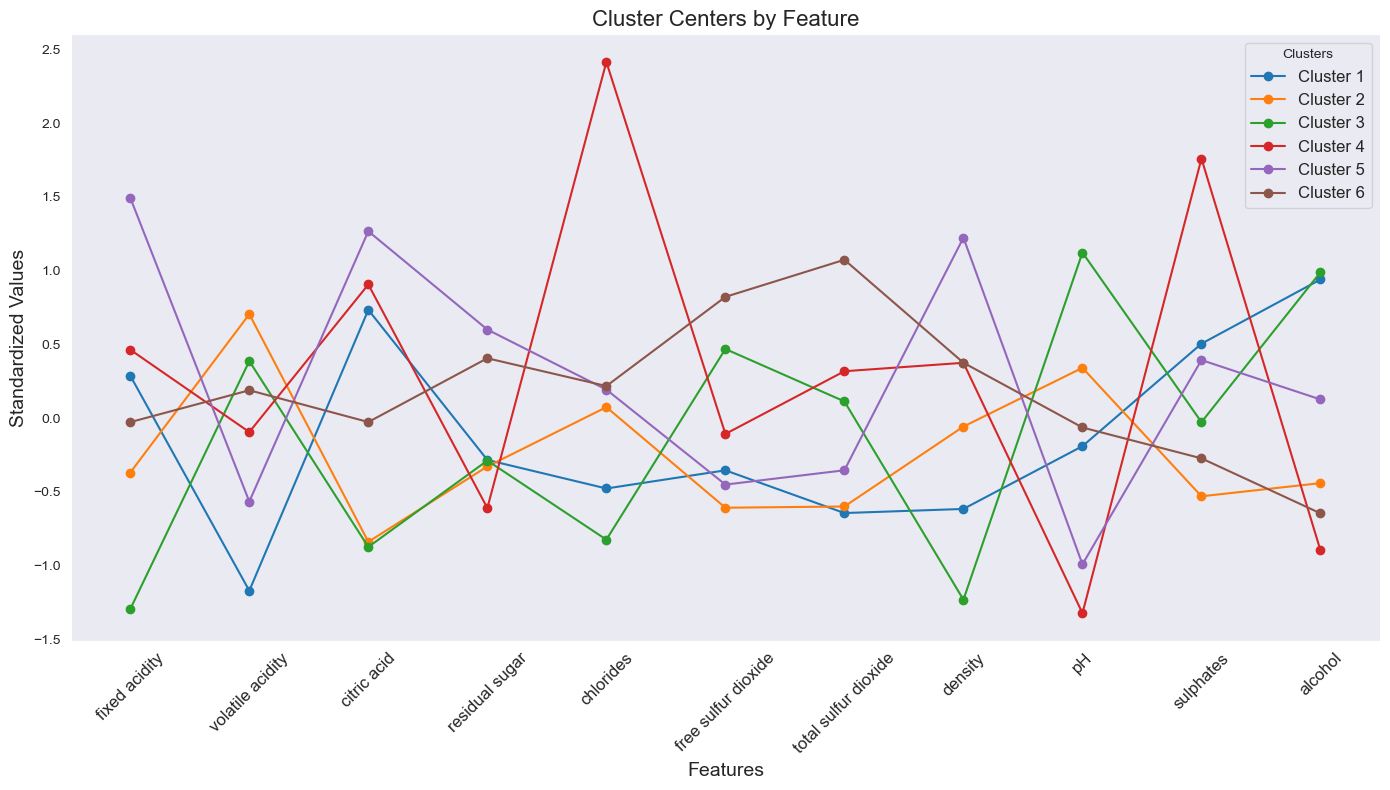

In [107]:
plt.figure(figsize=(14, 8))

# Iterate over each cluster (row in DataFrame)
for cluster_idx in cluster_centers_df.index:
    plt.plot(
        cluster_centers_df.columns,  # Features as x-axis
        cluster_centers_df.loc[cluster_idx],  # Values for this cluster
        marker='o', 
        label=f'Cluster {cluster_idx + 1}'
    )

# Add labels, legend, and title
plt.xticks(rotation=45, fontsize=12)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Standardized Values", fontsize=14)
plt.title("Cluster Centers by Feature", fontsize=16)
plt.legend(title="Clusters", fontsize=12)
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()

In [97]:
# Transpose the DataFrame for easier plotting
cluster_centers_transposed = cluster_centers_df.T
cluster_centers_transposed


,0,1,2,3,4,5
fixed acidity,0.287107,-0.370077,-1.296456,0.463386,1.494158,-0.027897
volatile acidity,-1.171906,0.704617,0.386428,-0.095438,-0.566915,0.188304
citric acid,0.734000,-0.840004,-0.874995,0.905998,1.267070,-0.027253
residual sugar,-0.284555,-0.328742,-0.288705,-0.610690,0.600176,0.405470
chlorides,-0.478170,0.073819,-0.825361,2.415641,0.192762,0.216878
free sulfur dioxide,-0.354952,-0.608665,0.468305,-0.108145,-0.451586,0.821948
total sulfur dioxide,-0.644804,-0.600358,0.112613,0.317398,-0.354612,1.073572
density,-0.616953,-0.057968,-1.232666,0.374658,1.223522,0.375088
pH,-0.191042,0.340482,1.122787,-1.324220,-0.992850,-0.064297
sulphates,0.504248,-0.531099,-0.027958,1.759894,0.393130,-0.273715


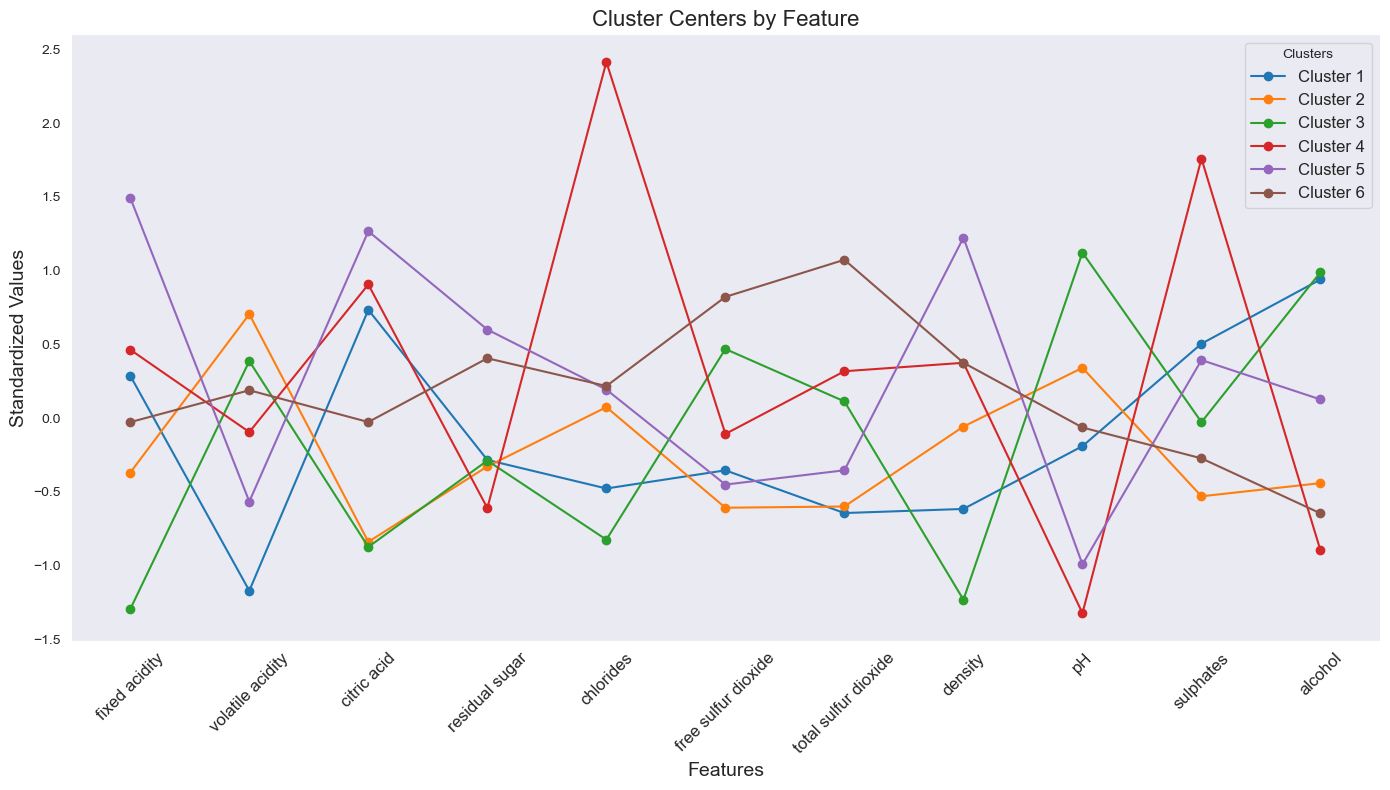

In [102]:

# Create a line plot
plt.figure(figsize=(14, 8))
for cluster_idx in cluster_centers_transposed.columns:
    plt.plot(
        cluster_centers_transposed.index, 
        cluster_centers_transposed[cluster_idx], 
        marker='o', 
        label=f'Cluster {cluster_idx + 1}'
    )

# Add labels, legend, and title
plt.xticks(rotation=45, fontsize=12)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Standardized Values", fontsize=14)
plt.title("Cluster Centers by Feature", fontsize=16)
plt.legend(title="Clusters", fontsize=12)
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()

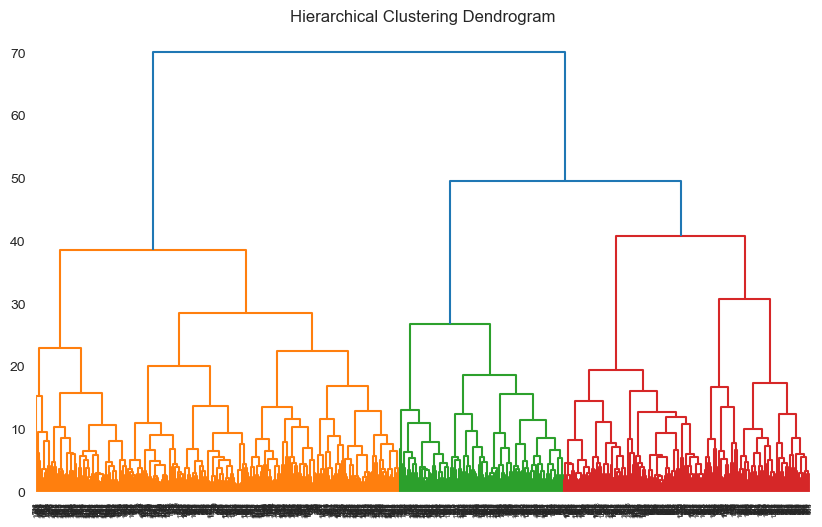

In [26]:

# Hierarchical Clustering
linkage_matrix = linkage(Train_scaled, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()


hierarchical_clusters = fcluster(linkage_matrix, t=6, criterion='maxclust')
tsne_data['hierarchical_cluster'] = hierarchical_clusters


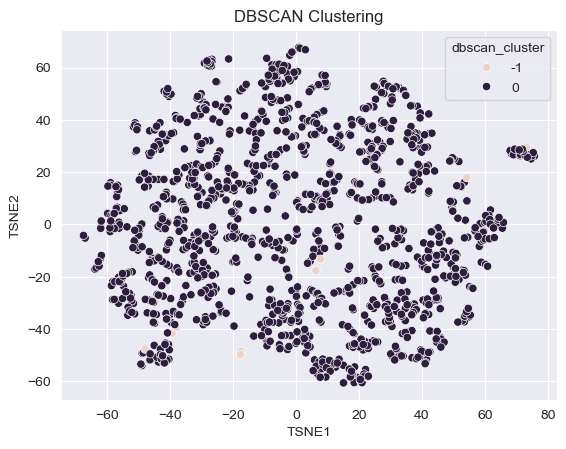

In [40]:

# DBSCAN
dbscan = DBSCAN(eps=3, min_samples=5)
tsne_data['dbscan_cluster'] = dbscan.fit_predict(Train_scaled)

sns.scatterplot(data=tsne_data, x='TSNE1', y='TSNE2', hue='dbscan_cluster')
plt.title('DBSCAN Clustering')
plt.show()

